In [1]:
%pip install -q sparqlwrapper wikipedia-api pykeen torch transformers evaluate rouge_score sacrebleu scikit-learn
%python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.3/730.3 kB 16.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 37.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [13]:
import time
from SPARQLWrapper import SPARQLWrapper, JSON
import wikipediaapi

from datasets import load_dataset
import spacy
import pandas as pd
import networkx as nx
import json
import re

import torch
import numpy as np
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer

import torch.nn as nn
from transformers import T5ForConditionalGeneration
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers.modeling_outputs import BaseModelOutput

2025-12-25 09:47:24.533412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766656044.718258      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766656044.774466      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766656045.242299      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766656045.242339      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766656045.242342      55 computation_placer.cc:177] computation placer alr

# сбор данных и подготовка

In [4]:
nlp = spacy.load("en_core_web_sm")

limit = 1000 

def add_rel(key, pred, result, kg_data):
    if key in result:
        val = result[key]["value"]

        if "http" not in val: 
            kg_data[e_id]["relations"].add((e_name, pred, val))


sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

query = f"""
SELECT ?entity ?entityLabel ?positionLabel ?partyLabel ?birthDateLabel WHERE {{
  {{
    SELECT DISTINCT ?entity WHERE {{
      ?entity wdt:P31 wd:Q5;          # Человек
              wdt:P39 ?position.      # Занимает должность
      ?article schema:about ?entity;
                schema:isPartOf <https://en.wikipedia.org/>.
    }}
    LIMIT {limit}
  }}
  
  ?entity wdt:P39 ?position.
  OPTIONAL {{ ?entity wdt:P102 ?party. }}
  OPTIONAL {{ ?entity wdt:P569 ?birthDate. }}

  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
}}
"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results = sparql.query().convert()

kg_data = {}

for result in results["results"]["bindings"]:
    e_uri = result["entity"]["value"] #ID сущности (например, Q76)
    e_id = e_uri.split("/")[-1]
    e_name = result["entityLabel"]["value"]

    if e_id not in kg_data:
        kg_data[e_id] = {
            "name": e_name,
            "relations": set()
        }

    add_rel("positionLabel", "holds_position", result, kg_data)
    add_rel("partyLabel", "member_of_political_party", result, kg_data)
    
    # берем только год для простоты
    if "birthDateLabel" in result:
        date_val = result["birthDateLabel"]["value"]
        year = date_val[:4]
        kg_data[e_id]["relations"].add((e_name, "born_in_year", year))

print(f"Найдено сущностей в графе: {len(kg_data)}") 

Найдено сущностей в графе: 1000


In [5]:
wiki_wiki = wikipediaapi.Wikipedia(
    user_agent='SNA-project/1.0 (iakhamganov@edu.hse.ru)',
    language='en',
    extract_format=wikipediaapi.ExtractFormat.WIKI
)

dataset = []

for e_id, info in list(kg_data.items()):
    
    page = wiki_wiki.page(info['name'])
    
    if not page.exists():
        print(f"отсутствует: {info['name']}")
        continue

    summary_text = page.summary #смак данных
    
    if len(summary_text) < 50:
        continue

    dataset.append({
        "entity_id": e_id,
        "entity_name": info['name'],
        "triples": list(info['relations']),
        "full_text": summary_text
    })
    
    time.sleep(0.5)

отсутствует: Gerren
отсутствует: Ranbir Singh I of Jind
отсутствует: Madansinh I of Kutch
отсутствует: Adolf I, Duke of Schleswig-Holstein-Gottorp
отсутствует: Prince Aimone, 4th Duke of Aosta
отсутствует: ʿUmar Tal
отсутствует: Milan I Obrenović
отсутствует: Aimery II de Lusignan
отсутствует: Sumalia Ndewura Jakpa
отсутствует: Oba Mufutau Gbadamosi Esuwoye
отсутствует: Zimri–lim
отсутствует: Chungnyeol
отсутствует: Sumu-epukh
отсутствует: Alric
отсутствует: Heonae
отсутствует: Samsènethaï
отсутствует: M'siri
отсутствует: Hamilton Chamberlain Jones III
отсутствует: Raymond Smiley Springer
отсутствует: Samuel Francis Hobbs
отсутствует: Yuhi VI
отсутствует: Bhushan Ramkrishan Gavai
отсутствует: John Hugh of Orsbeck
отсутствует: Isabella I, Queen of Armenia
отсутствует: Costanza I of Sicily
отсутствует: Nzingha Mbande
отсутствует: Mullissu-mukannišat-Ninua
отсутствует: Lady GI-K'awiil of Cancuén
отсутствует: Q69650
отсутствует: Q71659
отсутствует: Q71660
отсутствует: Q71674
отсутствует: Q

In [6]:
raw_dataset = dataset
len(raw_dataset)

931

**Выравнивание и препроцессинг**

In [8]:
def clean_sentence(text):
    text = re.sub(r'\[\d+\]', '', text) 
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def linearize_graph(triples):
    # Превращаем граф в строку: <H> Subj <R> Pred <T> Obj
    linearized = []
    for subj, pred, obj in triples:
        linearized.append(f"<H> {subj} <R> {pred} <T> {obj}")
    return " [SEP] ".join(linearized)

def align_and_generate_samples(dataset):
    final_samples = []
    
    for entry in dataset:
        doc = nlp(entry['full_text'])
        all_triples = entry['triples']
        
        for sent in doc.sents:
            sent_text = clean_sentence(sent.text)
            if len(sent_text) < 20: continue
            
            matched_triples = []
            
            for subj, pred, obj in all_triples:
                if obj in sent_text:
                    matched_triples.append((subj, pred, obj))
            
            if matched_triples:
                sample = {
                    "input_graph": linearize_graph(matched_triples),
                    "target_text": sent_text,
                    "entity": entry['entity_name']
                }
                final_samples.append(sample)
                
    return final_samples

In [20]:
training_data = align_and_generate_samples(dataset)
print(len(training_data))
print(training_data[0]['input_graph'][:100])

1200
<H> Bitòn Coulibaly <R> born_in_year <T> 1689


In [21]:
triples_list = []
for q_id, info in kg_data.items():
    for triple in info['relations']:
        triples_list.append(list(triple))

triples_np = np.array(triples_list)
print(f"Всего фактов в базе знаний: {len(triples_np)}")

Всего фактов в базе знаний: 4266


In [22]:
tf = TriplesFactory.from_labeled_triples(triples_np)
entity_to_id = tf.entity_to_id
relation_to_id = tf.relation_to_id

print(f"Entities: {tf.num_entities}, Relations: {tf.num_relations}")

Entities: 2397, Relations: 3


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Обучение TransE

In [19]:
result = pipeline(
    training=tf,
    testing=tf, 
    model='TransE',
    
    model_kwargs={'embedding_dim': 64},
    optimizer='Adam',
    optimizer_kwargs={'lr': 0.01},
    training_kwargs={'num_epochs': 100},
    
    random_seed=42,
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/17.0 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/4.27k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.27s seconds


In [24]:
model_ke = result.model
entity_embeddings_matrix = model_ke.entity_representations[0](indices=None).detach().cpu().numpy()

entity_embedding_dict = {}
for entity_name, entity_id in entity_to_id.items():
    vector = entity_embeddings_matrix[entity_id]
    entity_embedding_dict[entity_name] = vector

In [26]:
sample_key = list(entity_embedding_dict.keys())[0]
print(f"Vector shape'{sample_key}': {entity_embedding_dict[sample_key].shape}")

Vector shape''Amr III ibn al-Mundhir': (64,)


# mechanisms to incorporate these embeddings as additional inputs or conditioning contexts for language models.

In [27]:
class GraphTextDataset(Dataset):
    def __init__(self, data, entity_embeddings, tokenizer, max_len=128):
        self.data = data
        self.entity_embeddings = entity_embeddings
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.embedding_dim = 64

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        input_text = "generate text from graph: " + item['input_graph']
        target_text = item['target_text']
        entity_name = item['entity']

        source = self.tokenizer(
            input_text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
        )
        target = self.tokenizer(
            target_text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
        )

        if entity_name in self.entity_embeddings:
            graph_vec = torch.tensor(self.entity_embeddings[entity_name], dtype=torch.float32)
        else:
            graph_vec = torch.zeros(self.embedding_dim, dtype=torch.float32)

        return {
            "input_ids": source["input_ids"].squeeze(), 
            "attention_mask": source["attention_mask"].squeeze(),
            "labels": target["input_ids"].squeeze(),
            "graph_vector": graph_vec
        }

tokenizer = T5Tokenizer.from_pretrained("t5-small")

train_data, val_data = train_test_split(training_data, test_size=0.15, random_state=42)

print(f"Train size: {len(train_data)}")
print(f"Val size:   {len(val_data)}")

train_dataset = GraphTextDataset(train_data, entity_embedding_dict, tokenizer)
val_dataset = GraphTextDataset(val_data, entity_embedding_dict, tokenizer)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Train size: 1020
Val size:   180


In [28]:
class GraphAugmentedT5(nn.Module):
    def __init__(self, model_name, graph_dim=64):
        super().__init__()
        self.t5 = T5ForConditionalGeneration.from_pretrained(model_name)
        self.hidden_dim = self.t5.config.d_model
        
        self.graph_projector = nn.Linear(graph_dim, self.hidden_dim)
        nn.init.xavier_uniform_(self.graph_projector.weight)

    def _prepare_inputs(self, input_ids, attention_mask, graph_vector):
        inputs_embeds = self.t5.shared(input_ids)
        graph_emb = self.graph_projector(graph_vector).unsqueeze(1)
        inputs_embeds_combined = torch.cat([graph_emb, inputs_embeds], dim=1)
        
        bs = attention_mask.shape[0]
        ones = torch.ones((bs, 1), device=attention_mask.device, dtype=attention_mask.dtype)
        extended_mask = torch.cat([ones, attention_mask], dim=1)
        return inputs_embeds_combined, extended_mask

    def forward(self, input_ids, attention_mask, graph_vector, labels=None):
        emb, mask = self._prepare_inputs(input_ids, attention_mask, graph_vector)
        return self.t5(inputs_embeds=emb, attention_mask=mask, labels=labels)

    def generate(self, input_ids, attention_mask, graph_vector, max_length=100):
        emb, mask = self._prepare_inputs(input_ids, attention_mask, graph_vector)
        return self.t5.generate(
            inputs_embeds=emb, attention_mask=mask, max_length=max_length,
            num_beams=4, no_repeat_ngram_size=2, early_stopping=True
        )

model = GraphAugmentedT5(model_name="t5-small", graph_dim=64)
model.to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

GraphAugmentedT5(
  (t5): T5ForConditionalGeneration(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_featur

In [29]:
LEARNING_RATE = 3e-4
NUM_EPOCHS = 5 
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float('inf')
loss_history = []


for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False)
    
    for batch in pbar:
        optimizer.zero_grad()
        loss = model(
            batch['input_ids'].to(device), 
            batch['attention_mask'].to(device), 
            batch['graph_vector'].to(device), 
            labels=batch['labels'].to(device)
        ).loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train = train_loss / len(train_loader)
    loss_history.append(avg_train)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            loss = model(
                batch['input_ids'].to(device), 
                batch['attention_mask'].to(device), 
                batch['graph_vector'].to(device), 
                labels=batch['labels'].to(device)
            ).loss
            val_loss += loss.item()
    
    avg_val = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss={avg_train:.4f} | Val Loss={avg_val:.4f}")
    
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), "best_graph_t5.pth")

Ep 1:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1: Train Loss=1.5339 | Val Loss=1.1076


Ep 2:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.0410 | Val Loss=1.0387


Ep 3:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.9640 | Val Loss=1.0024


Ep 4:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.9161 | Val Loss=0.9802


Ep 5:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.8714 | Val Loss=0.9721


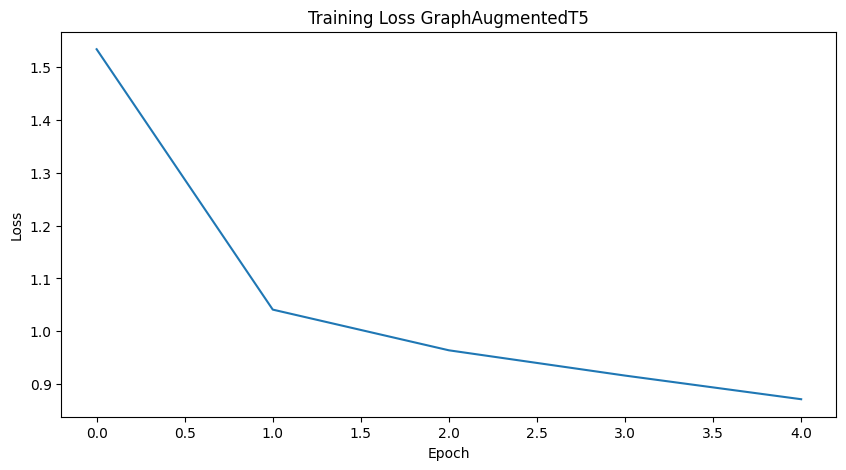

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Training Loss GraphAugmentedT5")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [31]:
model.load_state_dict(torch.load("/kaggle/working/best_graph_t5.pth"))
model.eval()

with torch.no_grad():
    batch = next(iter(val_loader))
    input_ids = batch['input_ids'][0:1].to(device)
    mask = batch['attention_mask'][0:1].to(device)
    graph_vec = batch['graph_vector'][0:1].to(device)
    
    out = model.generate(input_ids, mask, graph_vec, max_length=80)
    print(f"Gen: {tokenizer.decode(out[0], skip_special_tokens=True)}")

Gen: He is a member of the Liberal Democrats and is the first person to have been elected to the House of Representatives.


## Graph Transformer model, совмещающая текстовые и графовые данные

In [32]:
class HybridGraphT5(nn.Module):
    def __init__(self, model_name, graph_dim=64):
        super().__init__()
        self.t5 = T5ForConditionalGeneration.from_pretrained(model_name)
        self.hidden_dim = self.t5.config.d_model
        
        self.graph_projector = nn.Linear(graph_dim, self.hidden_dim)
        self.fusion_norm = nn.LayerNorm(self.hidden_dim)
        nn.init.xavier_uniform_(self.graph_projector.weight)

    def _fuse(self, ids, mask, g_vec):
        enc_out = self.t5.encoder(input_ids=ids, attention_mask=mask).last_hidden_state
        g_emb = self.fusion_norm(self.graph_projector(g_vec).unsqueeze(1))
        fused = torch.cat([enc_out, g_emb], dim=1)
        
        bs = mask.shape[0]
        ones = torch.ones((bs, 1), device=mask.device, dtype=mask.dtype)
        fused_mask = torch.cat([mask, ones], dim=1)
        return fused, fused_mask

    def forward(self, input_ids, attention_mask, graph_vector, labels=None):
        fused, mask = self._fuse(input_ids, attention_mask, graph_vector)
        return self.t5(encoder_outputs=BaseModelOutput(last_hidden_state=fused), attention_mask=mask, labels=labels)

    def generate(self, input_ids, attention_mask, graph_vector, max_length=100):
        fused, mask = self._fuse(input_ids, attention_mask, graph_vector)
        return self.t5.generate(
            encoder_outputs=BaseModelOutput(last_hidden_state=fused), attention_mask=mask, 
            max_length=max_length, num_beams=4, no_repeat_ngram_size=2, early_stopping=True
        )

hybrid_model = HybridGraphT5(model_name="t5-small", graph_dim=64)
hybrid_model.to(device)
print("HybridT5")

HybridT5


In [33]:
optimizer = optim.AdamW(hybrid_model.parameters(), lr=3e-4)
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    hybrid_model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False)
    
    for batch in pbar:
        optimizer.zero_grad()
        loss = hybrid_model(
            batch['input_ids'].to(device), 
            batch['attention_mask'].to(device), 
            batch['graph_vector'].to(device), 
            labels=batch['labels'].to(device)
        ).loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    avg_train = train_loss / len(train_loader)
    
    hybrid_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            loss = hybrid_model(
                batch['input_ids'].to(device), 
                batch['attention_mask'].to(device), 
                batch['graph_vector'].to(device), 
                labels=batch['labels'].to(device)
            ).loss
            val_loss += loss.item()
    
    avg_val = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss={avg_train:.4f} | Val Loss={avg_val:.4f}")
    
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(hybrid_model.state_dict(), "best_hybrid_t5.pth")

Ep 1:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1: Train Loss=2.0254 | Val Loss=1.2135


Ep 2:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.1526 | Val Loss=1.0770


Ep 3:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 3: Train Loss=1.0143 | Val Loss=1.0294


Ep 4:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.9583 | Val Loss=0.9981


Ep 5:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.9140 | Val Loss=0.9820


In [34]:
hybrid_model.load_state_dict(torch.load("/kaggle/working/best_hybrid_t5.pth"))
hybrid_model.eval()

with torch.no_grad():
    batch = next(iter(val_loader))
    out = hybrid_model.generate(batch['input_ids'][0:1].to(device), batch['attention_mask'][0:1].to(device), batch['graph_vector'][0:1].to(device), max_length=80)
    print(f"Hybrid Gen: {tokenizer.decode(out[0], skip_special_tokens=True)}")

Hybrid Gen: He is a member of the Liberal Democrats, part of an alliance of Liberals and Democrats.


In [35]:
import nltk
import evaluate
nltk.download('wordnet')
nltk.download('punkt')
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# Оценка метрик

In [38]:
def calculate_metrics(model, dataloader, tokenizer, device='cuda'):
    model.eval()
    predictions, references, inputs_graphs = [], [], []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            graph_vec = batch['graph_vector'].to(device)
            
            gen_tokens = model.generate(
                input_ids, mask, graph_vec, max_length=128, 
            )
            
            preds = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True)
            
            labels = batch['labels'].cpu().numpy()
            labels[labels == -100] = tokenizer.pad_token_id
            refs = tokenizer.batch_decode(labels, skip_special_tokens=True)
            
            in_graphs = tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=False)
            
            predictions.extend(preds)
            references.extend(refs)
            inputs_graphs.extend(in_graphs)

    b = bleu.compute(predictions=predictions, references=[[r] for r in references])
    r = rouge.compute(predictions=predictions, references=references)
    m = meteor.compute(predictions=predictions, references=references)
    
    return {
        "BLEU": b['bleu'], "ROUGE-L": r['rougeL'], "METEOR": m['meteor']
    }, inputs_graphs, predictions, references

In [39]:
scores_hyb, _, preds_hyb, _ = calculate_metrics(hybrid_model, val_loader, tokenizer, device)

# model.load_state_dict(torch.load("best_graph_t5.pth"))
scores_g5, _, preds_g5, _ = calculate_metrics(model, val_loader, tokenizer, device)

df = pd.DataFrame([scores_hyb, scores_g5], index=['Hybrid', 'GraphT5'])
print(df)

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

             BLEU   ROUGE-L    METEOR
Hybrid   0.123476  0.322376  0.297587
GraphT5  0.123171  0.326577  0.300913


In [40]:
val_raw_inputs = [item['input_graph'] for item in val_data]

min_len = min(len(val_raw_inputs), len(preds_g5))
val_raw_inputs = val_raw_inputs[:min_len]
preds_g5 = preds_g5[:min_len]
preds_hyb = preds_hyb[:min_len]

def calc_coverage(inputs, preds):
    total, covered = 0, 0
    regex = r"<T>\s*(.*?)(?=\s*(?:\[SEP\]|<H>|$))"
    for inp, pred in zip(inputs, preds):
        objs = [m.strip() for m in re.findall(regex, inp) if len(m.strip()) > 0]
        for o in objs:
            total += 1
            if o.lower() in pred.lower():
                covered += 1
    return covered / total if total > 0 else 0

print(f"GraphT5 Coverage: {calc_coverage(val_raw_inputs, preds_g5)*100:.2f}%")
print(f"Hybrid Coverage:  {calc_coverage(val_raw_inputs, preds_hyb)*100:.2f}%")

GraphT5 Coverage: 93.69%
Hybrid Coverage:  91.89%


# Создание и обучение бейзлайна 

In [41]:
class BaselineTextDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = f"generate text about {item['entity']}:"
        
        target_text = item['target_text']

        source = self.tokenizer(
            input_text, 
            max_length=self.max_len, 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt"
        )
        
        target = self.tokenizer(
            target_text, 
            max_length=self.max_len, 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt"
        )

        return {
            "input_ids": source["input_ids"].squeeze(), 
            "attention_mask": source["attention_mask"].squeeze(),
            "labels": target["input_ids"].squeeze(),
        }

In [42]:
BATCH_SIZE = 4
train_dataset_base = BaselineTextDataset(train_data, tokenizer)
train_loader_base = DataLoader(train_dataset_base, batch_size=BATCH_SIZE, shuffle=True)

val_dataset_base = BaselineTextDataset(val_data, tokenizer)
val_loader_base = DataLoader(val_dataset_base, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
baseline_model = T5ForConditionalGeneration.from_pretrained("t5-small")
baseline_model.to(device)

optimizer = optim.AdamW(hybrid_model.parameters(), lr=3e-4)
best_val_loss = float('inf')
history_loss = []

for epoch in range(NUM_EPOCHS):
    hybrid_model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False)
    
    for batch in pbar:
        optimizer.zero_grad()
        loss = baseline_model(
            input_ids=batch['input_ids'].to(device), 
            attention_mask=batch['attention_mask'].to(device), 
            labels=batch['labels'].to(device)
        ).loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        history_loss.append(loss.item())
        
    avg_train = train_loss / len(train_loader)
    
    hybrid_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            loss = hybrid_model(
                batch['input_ids'].to(device), 
                batch['attention_mask'].to(device), 
                batch['graph_vector'].to(device), 
                labels=batch['labels'].to(device)
            ).loss
            val_loss += loss.item()
    
    avg_val = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss={avg_train:.4f} | Val Loss={avg_val:.4f}")
    
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(hybrid_model.state_dict(), "best_baseline_t5_split.pth")

Ep 1:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1: Train Loss=11.1535 | Val Loss=0.9820


Ep 2:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 2: Train Loss=11.1523 | Val Loss=0.9820


Ep 3:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 3: Train Loss=11.1537 | Val Loss=0.9820


Ep 4:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 4: Train Loss=11.1525 | Val Loss=0.9820


Ep 5:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 5: Train Loss=11.1516 | Val Loss=0.9820


In [45]:
def evaluate_baseline_on_val(model, val_loader, tokenizer):
    model.eval()
    predictions = []
    references = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            
            gen_tokens = model.generate(
                input_ids=input_ids,       
                attention_mask=mask,      
                max_length=100,
                num_beams=4,
                no_repeat_ngram_size=2,
                early_stopping=True
            )
            
            preds = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True)
            
            labels = batch['labels'].cpu().numpy()
            labels[labels == -100] = tokenizer.pad_token_id
            refs = tokenizer.batch_decode(labels, skip_special_tokens=True)
            
            predictions.extend(preds)
            references.extend(refs)
            
    b_score = bleu.compute(predictions=predictions, references=[[r] for r in references])
    r_score = rouge.compute(predictions=predictions, references=references)
    
    return {
        "BLEU": b_score['bleu'],
        "ROUGE-1": r_score['rouge1'],
        "ROUGE-L": r_score['rougeL']
    }, predictions, references

metrics_base, preds_base, refs_base = evaluate_baseline_on_val(baseline_model, val_loader_base, tokenizer)

df_res = pd.DataFrame([metrics_base])
df_res.index = ["Baseline"]
print(df_res)

  0%|          | 0/45 [00:00<?, ?it/s]

              BLEU   ROUGE-1   ROUGE-L
Baseline  0.002615  0.112024  0.110062


In [47]:
val_graphs = [item['input_graph'] for item in val_data]

min_len = min(len(val_graphs), len(preds_base))
val_graphs = val_graphs[:min_len]
preds_base = preds_base[:min_len]

def evaluate_factual_coverage_v2(inputs, predictions):
    total_facts = 0
    covered_facts = 0
    regex_pattern = r"<T>\s*(.*?)(?=\s*(?:\[SEP\]|<H>|$))"
    for graph_str, pred_text in zip(inputs, predictions):
        matches = re.findall(regex_pattern, graph_str)
        objects = [m.strip() for m in matches if len(m.strip()) > 0]
        for obj in objects:
            total_facts += 1
            if obj.lower() in pred_text.lower():
                covered_facts += 1
    return covered_facts / total_facts if total_facts > 0 else 0

fact_cov_base = evaluate_factual_coverage_v2(val_graphs, preds_base)

print(f"Factual Coverage: {fact_cov_base*100:.2f}%")

Factual Coverage: 4.50%


# Analysis and Deployment

## Quantitative

In [67]:
df_metrics = pd.concat([df_res, df], axis=0)
df_metrics['factual coverage'] = [fact_cov_base,
                                    calc_coverage(val_raw_inputs, preds_hyb)*100,
                                    calc_coverage(val_raw_inputs, preds_g5)*100]
df_metrics.index.name = "Model"
df_metrics = df_metrics.reset_index()
df_metrics

,Model,BLEU,ROUGE-1,ROUGE-L,METEOR,factual coverage
0,Baseline,0.002615,0.112024,0.110062,NaN,0.045045
1,Hybrid,0.123476,NaN,0.322376,0.297587,91.891892
2,GraphT5,0.123171,NaN,0.326577,0.300913,93.693694


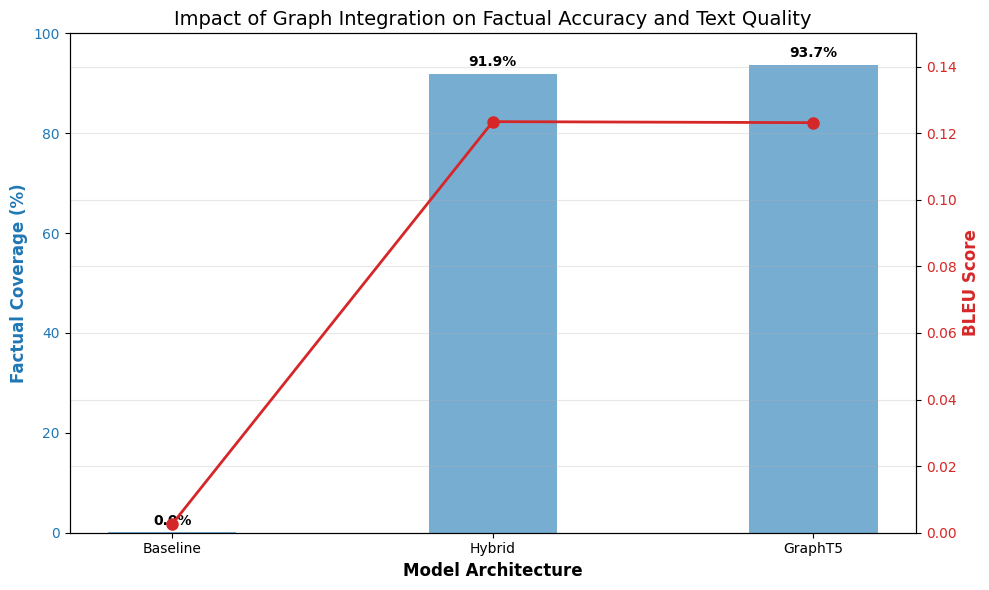

In [69]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Model Architecture', fontsize=12, fontweight='bold')
ax1.set_ylabel('Factual Coverage (%)', color=color, fontsize=12, fontweight='bold')
bars = ax1.bar(df_metrics["Model"], df_metrics["factual coverage"], color=color, alpha=0.6, width=0.4, label='Factual Coverage')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('BLEU Score', color=color, fontsize=12, fontweight='bold')  
line = ax2.plot(df_metrics["Model"], df_metrics["BLEU"], color=color, marker='o', linewidth=2, markersize=8, label='BLEU')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 0.15) 

plt.title("Impact of Graph Integration on Factual Accuracy and Text Quality", fontsize=14)
fig.tight_layout()
plt.grid(True, axis='y', alpha=0.3)
plt.show()

## Qualitative

In [77]:
def print_comparative_analysis(dataset, model_baseline, model_graph, tokenizer, num_samples=3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_baseline.eval()
    model_graph.eval()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx in indices:
        item = dataset[idx]
        # entity_name = item['entity']
        
        ids = item['input_ids'].unsqueeze(0).to(device)
        mask = item['attention_mask'].unsqueeze(0).to(device)
        g_vec = item['graph_vector'].unsqueeze(0).to(device)

        out_base = model_baseline.generate(input_ids=ids, attention_mask=mask, max_length=100)
  
        txt_base = tokenizer.decode(out_base[0], skip_special_tokens=True)
        
        out_graph = model_graph.generate(ids, mask, g_vec, max_length=100)
        txt_graph = tokenizer.decode(out_graph[0], skip_special_tokens=True)
        
        lbl = item['labels'].clone()
        lbl[lbl == -100] = tokenizer.pad_token_id
        txt_true = tokenizer.decode(lbl, skip_special_tokens=True)
        
        raw_graph = val_data[idx]['input_graph'] 
        
        print(f"#{idx} Entity: {val_data[idx]['entity']}")
        print(f"FACTS (Graph): {raw_graph[:150]}")
        print()
        print(f"BASELINE: {txt_base}")
        print(f"HYBRID:   {txt_graph}")
        print(f"REFERENCE: {txt_true}")

print_comparative_analysis(val_dataset, baseline_model, hybrid_model, tokenizer)

#142 Entity: Roy Jenkins
FACTS (Graph): <H> Roy Jenkins <R> member_of_political_party <T> Labour Party

BASELINE: H> Roy Jenkins R> member_of_political_party T> Labour Party T> Labour Party
HYBRID:   He was a member of the Labour Party from 1994 to 2009.
REFERENCE: After completing his term at the Commission in 1981, Jenkins announced a surprise return to British politics; dismayed with the Labour Party's move further left under the leadership of Michael Foot, he became one of the "Gang of Four", senior Labour figures who broke away from the party and founded the SDP.
#114 Entity: Clement Attlee
FACTS (Graph): <H> Clement Attlee <R> holds_position <T> Lord Privy Seal

BASELINE: Texte from graph: H> Clement Attlee R> holds_position T> Lord Privy Seal
HYBRID:   Clement Attlee was Lord Privy Seal of the United States from 1823 until his death in 1822.
REFERENCE: Attlee took Labour into the wartime coalition government in 1940 and served under Winston Churchill, initially as Lord Privy Sea